# Models 

> Implementation of key circadian models under the common framework of the `CircadianModel` and `DinamicalTrajectory` classes.

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp models

In [ ]:
#| export 
import time
import numpy as np
import pylab as plt
from functools import wraps
from abc import ABC, abstractmethod
from scipy.signal import find_peaks
from circadian.utils import phase_ic_guess
from typing import Tuple

In [ ]:
#| hide 
def benchmark(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [ ]:
#| hide
from nbdev.showdoc import *

Lets first define a helper class to store the solutions for differential equation models. 

In [ ]:
#| export 
class DynamicalTrajectory:
    """ 
    A class to store a solutions that contains both the time points and the states.
    """
    
    def __init__(self, 
                 ts: np.ndarray, # time points
                 states: np.ndarray # states at time points
                 ) -> None:
        self.ts = ts
        self.states = states
        
    def __call__(self, t: float) -> np.ndarray: # state of the system
        """ 
        Return the state at time t, linearly interpolated
        """
        return np.interp(t, self.ts, self.states)
    
    def __getitem__(self, idx: int) -> Tuple[float, np.ndarray]:
        return self.ts[idx], self.states[idx]
    
    def __len__(self) -> int:
        return len(self.ts)
    
    def get_batch(self,index: int) -> 'DynamicalTrajectory':
        if self.states.ndim >= 3:
            return DynamicalTrajectory(self.ts, self.states[index, :, :])
        else:
            return DynamicalTrajectory(self.ts, self.states)
        
    @property
    def batch_size(self) -> int:
        if self.states.ndim >= 3:
            return self.states.shape[0]
        else:
            return 1

In [ ]:
show_doc(DynamicalTrajectory.__call__) 

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L38){target="_blank" style="float:right; font-size:smaller"}

### DynamicalTrajectory.__call__

>      DynamicalTrajectory.__call__ (t:float)

Return the state at time t, linearly interpolated

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| t | float |  |
| **Returns** | **ndarray** | **state of the system** |

## Abstract Base Class: Circadian Model

In [ ]:
# | export
class CircadianModel(ABC):
    """ Abstract base class for circadian models, defines the interface for all models """

    def __init__(self, 
                 params: dict = None # dictionary of parameters for the model, if None then the default parameters are used
                 ):
        """ Creates a new instance of the model """
        pass

    @abstractmethod
    def _default_params(self) -> dict: # dictionary of default parameters for the model:
        """
            Defines the default parameters for the model
        """
        pass
    
    @property
    def get_parameters(self)-> dict:
        """
            Returns the parameters for the model
        """
        pass
    
    def set_parameters(self, 
                       param_dict: dict # dictionary of parameters for the model)
    ) -> None:
        """
            Sets the parameters for the model
        """

        for key, value in param_dict.items():
            setattr(self, key, value)

    def step_rk4(self,
                 state: np.ndarray, #dy/dt = f(y, t)
                 light_val: float, #light value at time t in lux
                 dt=0.10 #step size in hours 
                 ):
        """
            Return the state of the model assuming a constant light value
            for one time step and using a fourth order Runga-Kutta integrator to perform the step
        """
        k1 = self.derv(state, light=light_val)
        k2 = self.derv(state + k1 * dt / 2.0, light=light_val)
        k3 = self.derv(state + k2 * dt / 2.0, light=light_val)
        k4 = self.derv(state + k3 * dt, light=light_val)
        state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        return state

    def integrate_model(self,
                        ts: np.ndarray,  # Array of time points, also determines step size of RK4 solver
                        light_est: np.ndarray,  # Array of light estimates, should be the same length as ts
                        state: np.ndarray,  # Initial state of the model
                        ) -> DynamicalTrajectory:
        n = len(ts)
        sol = np.zeros((*state.shape, n))
        sol[..., 0] = state
        for idx in range(1, n):
            state = self.step_rk4(
                state=state,
                light_val=light_est[idx],
                dt=ts[idx]-ts[idx-1]
            )
            sol[..., idx] = state
        return DynamicalTrajectory(ts, sol)

    def dlmos(self, 
              trajectory: DynamicalTrajectory,  # solution from integrate_model
              ) -> np.ndarray: #array of times when the dlmo occurs for the model 
        """
            Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory
        """
        pass

    def cbt(self, 
            trajectory: DynamicalTrajectory,  # solution from integrate_model
            ) -> np.ndarray: # array of times when the cbt occurs
        """
            Finds the core body temperature minumum markers for the model along a trajectory
        """
        pass

    def observer(self,
                 trajectory: np.ndarray,  # solution from integrate_model
                 observer_func: callable, # function that takes the state of the model and returns a scalar will be triggered when the sign of the function changes
                 ) -> np.array: # this will return the times when the observer func changes signs
        """ 
            Defines a generic observer for the model, this will return the times when the observer_func changes sign
        """ 
        pass

    @staticmethod
    def amplitude(state: np.ndarray, #dynamic state of the model
                  ) -> float:
        """
            Gives the amplitude of the model at a given state
        """
        pass

    @staticmethod
    def phase(state: np.ndarray #dynamic state of the model
              ) -> float:
        """
            Gives the phase of the model at a given state
        """
        pass

    @property
    def default_initial_conditions(self) -> np.ndarray:
        """
        Defines some default initial conditions for the model
        """
        pass

    def __call__(self,
                 ts: np.ndarray,  # Array of time points, also determines step size of RK4 solver
                 light_est: np.ndarray,  # Array of light estimates, should be the same length as ts
                 state: np.ndarray,  # Initial state of the model
                 *args,
                 **kwargs):
        """ Wrapper to integrate_model, can just call the model object directly """
        return self.integrate_model(ts, light_est=light_est, state=state, *args, **kwargs)

    def initial_conditions_loop(self,
                                ts: np.ndarray, #Array of time points, also determines step size of RK4 solver
                                light_est: np.ndarray, #Array of light estimates, should be the same length as ts
                                num_loops: int = 30) -> np.ndarray: 
        """ 
            Estimate the starting values by looping the given light_estimate, commonly used for to estimate the initial conditions
            assumes the individual lives the same schedule repeatedly
        """
        ic = self.default_initial_conditions
        for _ in range(num_loops):
            sol = self.integrate_model(ts, light_est, ic).states
            ic = sol[..., -1]
        return ic


Each of the models can be initialized by using a dictionary of parameter values, although they have default parameter values taken from the publications. The dictionary passed can overwrite just one of the parameters and leave the remaining as the default values.

In [ ]:
show_doc(CircadianModel.__init__)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L69){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.__init__

>      CircadianModel.__init__ (params:dict=None)

Creates a new instance of the model

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| params | dict | None | dictionary of parameters for the model, if None then the default parameters are used |

The parameters for the model can be returned using

In [ ]:
show_doc(CircadianModel.get_parameters)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L83){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.get_parameters

>      CircadianModel.get_parameters ()

Returns the parameters for the model

In [ ]:
show_doc(CircadianModel.__call__)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L180){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.__call__

>      CircadianModel.__call__ (ts:numpy.ndarray, light_est:numpy.ndarray,
>                               state:numpy.ndarray, *args, **kwargs)

Wrapper to integrate_model, can just call the model object directly

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| ts | ndarray | Array of time points, also determines step size of RK4 solver |
| light_est | ndarray | Array of light estimates, should be the same length as ts |
| state | ndarray | Initial state of the model |
| args |  |  |
| kwargs |  |  |

In [ ]:
show_doc(CircadianModel.integrate_model)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L115){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.integrate_model

>      CircadianModel.integrate_model (ts:numpy.ndarray,
>                                      light_est:numpy.ndarray,
>                                      state:numpy.ndarray)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| ts | ndarray | Array of time points, also determines step size of RK4 solver |
| light_est | ndarray | Array of light estimates, should be the same length as ts |
| state | ndarray | Initial state of the model |
| **Returns** | **DynamicalTrajectory** |  |

In [ ]:

show_doc(CircadianModel.dlmos)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L132){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.dlmos

>      CircadianModel.dlmos (trajectory:__main__.DynamicalTrajectory)

Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trajectory | DynamicalTrajectory | solution from integrate_model |
| **Returns** | **ndarray** | **array of times when the dlmo occurs for the model** |

In [ ]:

show_doc(CircadianModel.cbt)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L140){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.cbt

>      CircadianModel.cbt (trajectory:__main__.DynamicalTrajectory)

Finds the core body temperature minumum markers for the model along a trajectory

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trajectory | DynamicalTrajectory | solution from integrate_model |
| **Returns** | **ndarray** | **array of times when the cbt occurs** |

In [ ]:

show_doc(CircadianModel.observer)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L148){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.observer

>      CircadianModel.observer (trajectory:numpy.ndarray, observer_func:<built-
>                               infunctioncallable>)

Defines a generic observer for the model, this will return the times when the observer_func changes sign

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trajectory | ndarray | solution from integrate_model |
| observer_func | callable | function that takes the state of the model and returns a scalar will be triggered when the sign of the function changes |
| **Returns** | **array** | **this will return the times when the observer func changes signs** |

In [ ]:

show_doc(CircadianModel.amplitude)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L158){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.amplitude

>      CircadianModel.amplitude (state:numpy.ndarray)

Gives the amplitude of the model at a given state

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | ndarray | dynamic state of the model |
| **Returns** | **float** |  |

In [ ]:

show_doc(CircadianModel.phase)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L166){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.phase

>      CircadianModel.phase (state:numpy.ndarray)

Gives the phase of the model at a given state

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | ndarray | dynamic state of the model |
| **Returns** | **float** |  |

In [ ]:

show_doc(CircadianModel.default_initial_conditions)


---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L174){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.default_initial_conditions

>      CircadianModel.default_initial_conditions ()

Defines some default initial conditions for the model

In [ ]:

show_doc(CircadianModel.initial_conditions_loop)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L189){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.initial_conditions_loop

>      CircadianModel.initial_conditions_loop (ts:numpy.ndarray,
>                                              light_est:numpy.ndarray,
>                                              num_loops:int=30)

Estimate the starting values by looping the given light_estimate, commonly used for to estimate the initial conditions
assumes the individual lives the same schedule repeatedly

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| ts | ndarray |  | Array of time points, also determines step size of RK4 solver |
| light_est | ndarray |  | Array of light estimates, should be the same length as ts |
| num_loops | int | 30 |  |
| **Returns** | **ndarray** |  |  |

In [ ]:
show_doc(CircadianModel.integrate_model)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L105){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.integrate_model

>      CircadianModel.integrate_model (ts:numpy.ndarray,
>                                      light_est:numpy.ndarray,
>                                      state:numpy.ndarray)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| ts | ndarray | Array of time points, also determines step size of RK4 solver |
| light_est | ndarray | Array of light estimates, should be the same length as ts |
| state | ndarray | Initial state of the model |
| **Returns** | **DynamicalTrajectory** |  |

In [ ]:
show_doc(CircadianModel.dlmos)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L122){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.dlmos

>      CircadianModel.dlmos (trajectory:__main__.DynamicalTrajectory)

Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trajectory | DynamicalTrajectory | solution from integrate_model |
| **Returns** | **ndarray** | **array of times when the dlmo occurs for the model** |

In [ ]:
show_doc(CircadianModel.cbt)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L130){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.cbt

>      CircadianModel.cbt (trajectory:__main__.DynamicalTrajectory)

Finds the core body temperature minumum markers for the model along a trajectory

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trajectory | DynamicalTrajectory | solution from integrate_model |
| **Returns** | **ndarray** | **array of times when the cbt occurs** |

In [ ]:
show_doc(CircadianModel.observer)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L138){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.observer

>      CircadianModel.observer (trajectory:numpy.ndarray, observer_func:<built-
>                               infunctioncallable>)

Defines a generic observer for the model, this will return the times when the observer_func changes sign

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| trajectory | ndarray | solution from integrate_model |
| observer_func | callable | function that takes the state of the model and returns a scalar will be triggered when the sign of the function changes |
| **Returns** | **array** | **this will return the times when the observer func changes signs** |

In [ ]:
show_doc(CircadianModel.amplitude)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L148){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.amplitude

>      CircadianModel.amplitude (state:numpy.ndarray)

Gives the amplitude of the model at a given state

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | ndarray | dynamic state of the model |
| **Returns** | **float** |  |

In [ ]:
show_doc(CircadianModel.phase)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L156){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.phase

>      CircadianModel.phase (state:numpy.ndarray)

Gives the phase of the model at a given state

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | ndarray | dynamic state of the model |
| **Returns** | **float** |  |

In [ ]:
show_doc(CircadianModel.default_initial_conditions)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L164){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.default_initial_conditions

>      CircadianModel.default_initial_conditions ()

Defines some default initial conditions for the model

In [ ]:
show_doc(CircadianModel.initial_conditions_loop)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L179){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.initial_conditions_loop

>      CircadianModel.initial_conditions_loop (ts:numpy.ndarray,
>                                              light_est:numpy.ndarray,
>                                              num_loops:int=30)

Estimate the starting values by looping the given light_estimate, commonly used for to estimate the initial conditions
assumes the individual lives the same schedule repeatedly

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| ts | ndarray |  | Array of time points, also determines step size of RK4 solver |
| light_est | ndarray |  | Array of light estimates, should be the same length as ts |
| num_loops | int | 30 |  |
| **Returns** | **ndarray** |  |  |

## Forger99 

This model is taken from [@forger_simpler_1999] which defines a simplification of previous iterations of the van der Pol based oscillator models published in the 1990s.  It is one of the most popular models in the circadian literature.  This implementation uses the parameters taken from [@serkh_optimal_2014] rather than the parameters from the original paper.


The model states are defined by three dynamic variables $(x, x_c, n)$. These states are related to circadian rhythms by defining the core body temperature minimum (a biomarker for circadian state) to be the minimum of the $x$ variable. 



In [ ]:
#| export
class Forger99Model(CircadianModel):
    """ Implementation of the Forger 1999 model """

    def __init__(self, params: dict= None):
        """
        Create a Forger VDP model 

        This will create a model with the default parameter values as given in Hannay et al 2019.

        This class can be used to simulate and plot the results of the given light schedule on the circadian phase
        and amplitude.
        """
        # Set the parameters to the published values by default
        self._default_params()
        
        if params:
            self.set_parameters(params)
        
        
    def _default_params(self):
        """
            Use the default parameters as defined in Hannay et al 2019
        """
        
        default_params = {'taux': 24.2,
                          'mu': 0.23,
                          'G': 33.75, 
                          'alpha_0': 0.05, 
                          'delta': 0.0075,
                          'p': 0.50, 
                          'I0': 9500.0, 
                          'kparam': 0.55}

        self.set_parameters(default_params)
        
    def set_parameters(self, param_dict: dict):
        """
            Update the model parameters using a passed in parameter dictionary. Any parameters not included
            in the dictionary will be set to the default values.

            updateParameters(param_dict)

            Returns null, changes the parameters stored in the class instance
        """
        

        params = [
            'taux',
            'mu'
            'G',
            'alpha_0',
            'delta',
            'p',
            'I0', 
            'kparam']

        for key, value in param_dict.items():
            setattr(self, key, value)
            
    def get_parameters_array(self):
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.taux, 
                         self.mu, 
                         self.G, 
                         self.alpha_0, 
                         self.delta, 
                         self.p, 
                         self.I0, 
                         self.kparam ])


    def get_parameters(self):
        """Get a dictionary of the current parameters being used by the model object.

        getParameters()

        returns a dict of parameters
        """

        current_params = {
            'taux': self.taux,
            'mu': self.mu,
            'G': self.G,
            'alpha_0': self.alpha_0,
            'delta': self.delta,
            'p': self.p,
            'I0': self.I0, 
            'kparam': self.kparam}

        return (current_params)

    def alpha0(self, 
               light: float # the light value in lux
               ):
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow((light / self.I0), self.p))

    def derv(self, 
             y: np.ndarray, # dynamical state (x, xc, n)
             light: float # light value in lux
             ) -> np.ndarray: # This defines the ode system for the forger 99 model

        x = y[...,0]
        xc = y[...,1]
        n = y[...,2]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light) * \
            (1 - 0.4 * x) * (1 - 0.4 * xc)

        dydt = np.zeros_like(y)
        dydt[...,0] = np.pi / 12.0 * (xc + Bhat)
        dydt[...,1] = np.pi / 12.0 * (self.mu * (xc - 4.0 / 3.0 * pow(xc, 3.0)) - x * (
            pow(24.0 / (0.99669 * self.taux), 2.0) + self.kparam * Bhat))
        dydt[...,2] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)

        return (dydt)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        cbt_mins = find_peaks(-1*trajectory.states[0,:])[0] # min of x is the CBTmin
        return trajectory.ts[cbt_mins]
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.cbt(trajectory) - 7.0 # dlmo is defines by a relationship to cbt for this model

    def amplitude(state) -> float:
        return np.sqrt(state[0]**2+state[1]**2)

    def phase(state) -> float:
        x= state[0] 
        y = state[1]*-1.0
        return np.angle(x + complex(0,1)*y)
        
    @property
    def default_initial_conditions(self) -> np.ndarray:
        """
        x= â€“0.3 and xc= â€“1.13 are the default initial conditions for the model
        should be the value near the habitual bed time of the individual. 
        """
        return np.array([-0.3,-1.13,0.0])
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Forger99Model"

In [ ]:
show_doc(Forger99Model.derv)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L304){target="_blank" style="float:right; font-size:smaller"}

### Forger99Model.derv

>      Forger99Model.derv (y:numpy.ndarray, light:float)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| y | ndarray | dynamical state (x, xc, n) |
| light | float | light value in lux |
| **Returns** | **ndarray** | **This defines the ode system for the forger 99 model** |

Here is how we can define the model and run a simulation

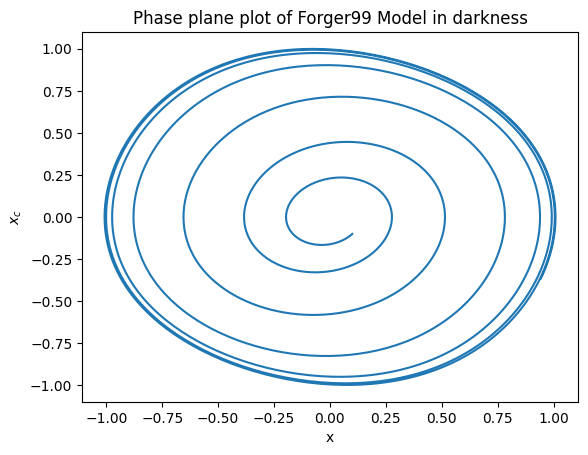

In [ ]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) # simulate in darkness
fmodel = Forger99Model()

trajectory = fmodel(ts, light_values, state=np.array([0.10,-0.10,0.0]))

plt.plot(trajectory.states[0,:], trajectory.states[1,:])
plt.title("Phase plane plot of Forger99 Model in darkness")
plt.xlabel("x")
plt.ylabel("$x_c$");


We can also make a time plot of the dynamics

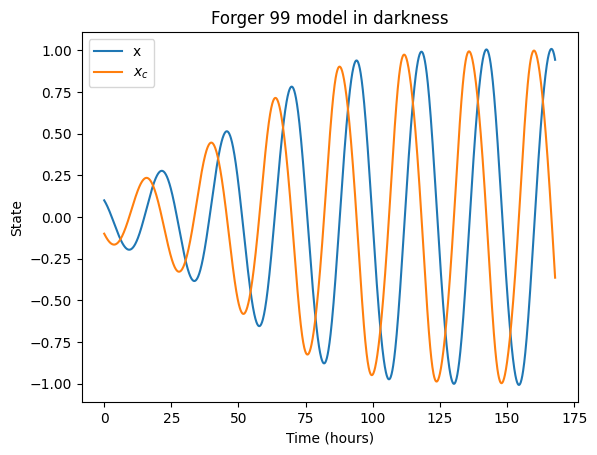

In [ ]:
# Integrate observer for the Forger 99 model

plt.plot(trajectory.ts, trajectory.states[0,:], label="x")
plt.plot(trajectory.ts, trajectory.states[1,:], label="$x_c$")
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Forger 99 model in darkness")
plt.legend()
plt.show();

We can also run a the model for a whole collection of initial conditions in one pass by just adding a batch dimension to the initial state. 
Here we show how to run the Forger model for 100 random initial conditions centered on an initial estimate. 

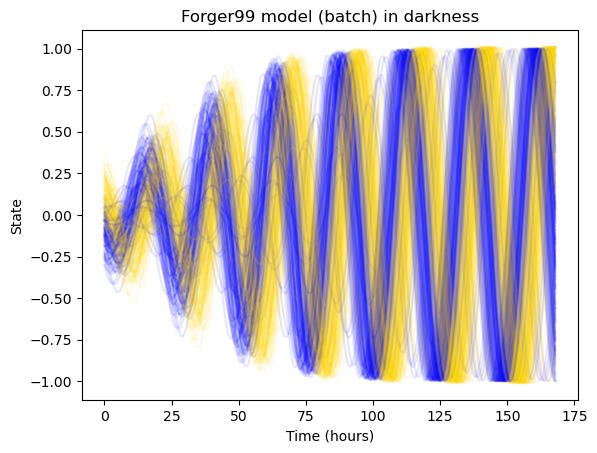

In [ ]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99Model()

initial_conditions_batch = np.array([0.10,-0.10,0.0]) + np.random.normal(0, 0.1, (100,3))

trajectory = fmodel.integrate_model(ts, 
                             light_values, 
                             state=initial_conditions_batch)

for i in range(100):
    plt.plot(trajectory.ts, trajectory.states[i,1,:], color='blue', alpha=0.1)
    plt.plot(trajectory.ts, trajectory.states[i,0,:], color='gold', alpha=0.1)
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Forger99 model (batch) in darkness")
plt.show();

Because adding a batch dimension is just using larger numpy arrays with the same vectorized operations under the hood we can run fairly larg batches with very little performance cost

In [ ]:
@benchmark
def batched_run(batch_size: int):
    initial_conditions_batch = np.array([0.10,-0.10,0.0]) + np.random.normal(0, 0.1, (batch_size,3))
    sol = fmodel.integrate_model(ts, 
                             light_values, 
                             state=initial_conditions_batch)

for i in [1,10,100,500,1000, 5000]:
    batched_run(i)

Function batched_run(1,) {} Took 0.1166 seconds
Function batched_run(10,) {} Took 0.1125 seconds
Function batched_run(100,) {} Took 0.1285 seconds
Function batched_run(500,) {} Took 0.1895 seconds
Function batched_run(1000,) {} Took 0.2711 seconds
Function batched_run(5000,) {} Took 0.9169 seconds


We can also easily get predictions of the Dim Light Melatonin Onset (DLMO) and Core Body Temperature minimum (CBT). The time between these markers gives the period of the oscillator over that time frame. 



In [ ]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99Model()

trajectory = fmodel(ts, light_values, state=np.array([0.10,-0.10,0.0]))

cbt = fmodel.cbt(trajectory)
dlmos = fmodel.dlmos(trajectory)

print(f"Hours between CBTs: {np.diff(cbt)}")
print(f"Hours between DLMOs: {np.diff(dlmos)}")

Hours between CBTs: [24.3 24.1 24.2 24.1 24.2 24.2]
Hours between DLMOs: [24.3 24.1 24.2 24.1 24.2 24.2]


The values away from 24.2 give the period while the transients die away from the initial conditions, you can see that the *freerunning* period (period with no light time cues) is 24.2 which roughly matches the average value from experimental studies. 

We can adjust this by passing in a custom parameter for $\tau_x$ (taux)


In [ ]:
fmodel_short_period = Forger99Model({ 'taux': 23.8})

trajectory = fmodel_short_period.integrate_model(ts,light_est=light_values, state=np.array([0.10,-0.10,0.0]))

dlmos = fmodel_short_period.dlmos(trajectory)
cbt = fmodel_short_period.cbt(trajectory)

print(f"Hours between DLMOs: {np.diff(dlmos)}")
print(f"Hours between CBTs: {np.diff(cbt)}")

Hours between DLMOs: [23.8 23.8 23.7 23.8 23.8 23.8]
Hours between CBTs: [23.8 23.8 23.7 23.8 23.8 23.8]


## Hannay19TP

This model defines the two population model from [@hannay_macroscopic_2019].Note, this model rotates counterclockwise in accordance with the usual convention in mathematics. The VDP family of models rotate clockwise. This can be confusing when trying
to compare phase plane plots between the models, but is fixable with a simple rotation.



In [ ]:
#| export
class Hannay19TP(CircadianModel):
    """  The Hannay et al 2019 two population model, which models the ventral and dorsal SCN populations """

    def __init__(self, 
                 params: dict= None # Dict of parameters to set, the published values are used by default
                 ) -> None:
        # Set the parameters to the published values by default
        self._default_params()
        if params:
            self.set_parameters(params)
        
    def _default_params(self) -> None:
        """
            Stores the default parameters for the model as published in Hannet et al 2019
        """
        
        default_params = {'tauV': 24.25,
                          'tauD': 24.0,
                          'Kvv': 0.05, 
                          'Kdd': 0.04,
                          'Kvd': 0.05,
                          'Kdv': 0.01,
                          'gamma': 0.024,
                          'A1': 0.440068, 
                          'A2': 0.159136,
                          'BetaL': 0.06452, 
                          'BetaL2': -1.38935, 
                          'sigma': 0.0477375,
                          'G': 33.75, 
                          'alpha_0': 0.05, 
                          'delta': 0.0075,
                          'p': 1.5, 
                          'I0': 9325.0}

        self.set_parameters(default_params)
        
    def set_parameters(self, 
                       param_dict: dict # Dict of parameters to set
                       ) -> None:

        params = [
            'tauV',
            'tauD',
            'Kvv',
            'Kdd',
            "Kvd",
            "Kdv",
            'gamma',
            'A1',
            'A2',
            'BetaL',
            'BetaL2',
            'sigma',
            'G',
            'alpha_0',
            'delta',
            'p',
            'I0']

        for key, value in param_dict.items():
            setattr(self, key, value)
            
    def get_parameters_array(self) -> np.ndarray: # Parameters as a numpy array
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.tauV, self.tauD, self.Kvv, self.Kdd, self.Kvd, self.Kdv, self.gamma, self.BetaL, self.BetaL2, self.A1, self.A2, self.sigma, self.G, self.alpha_0, self.delta, self.p, self.I0 ])

    @property
    def get_parameters(self) -> dict:
    
        current_params = {
            'tauV': self.w0,
            'tauD': self.tauD,
            'Kvv': self.Kvv,
            'Kdd': self.Kdd,
            'Kdv': self.Kdv,
            'Kvd': self.Kdv,
            'gamma': self.gamma,
            'A1': self.A1,
            'A2': self.A2,
            'BetaL': self.BetaL,
            'BetaL2': self.BetaL2,
            'sigma': self.sigma,
            'G': self.G,
            'alpha_0': self.alpha_0,
            'delta': self.delta,
            'p': self.p,
            'I0': self.I0}

        return (current_params)

    def alpha0(self, 
               light: float # light intensity in lux
               ) -> float: # Processed light intensity measure
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow(light, self.p) /
                (pow(light, self.p) + self.I0))

    def derv(self, 
             y: np.ndarray, # state vector for the dynamical system (Rv, Rd, Psiv, Psid, n)
             light: float, # light intensity in lux
             ) -> np.ndarray: # derivative of the state vector

        Rv = y[...,0]
        Rd = y[...,1]
        Psiv = y[...,2]
        Psid = y[...,3]
        n = y[...,4]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light)

        LightAmp = self.A1 * 0.5 * Bhat * (1.0 - pow(Rv, 4.0)) * np.cos(Psiv + self.BetaL) + self.A2 * 0.5 * Bhat * Rv * (
            1.0 - pow(Rv, 8.0)) * np.cos(2.0 * Psiv + self.BetaL2)
        LightPhase = self.sigma * Bhat - self.A1 * Bhat * 0.5 * (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(
            Psiv + self.BetaL) - self.A2 * Bhat * 0.5 * (1.0 + pow(Rv, 8.0)) * np.sin(2.0 * Psiv + self.BetaL2)

        dydt = np.zeros_like(y)
        dydt[...,0] = -self.gamma * Rv + self.Kvv / 2.0 * Rv * (1 - pow(Rv, 4.0)) + self.Kdv / 2.0 * Rd * (
            1 - pow(Rv, 4.0)) * np.cos(Psid - Psiv) + LightAmp
        dydt[...,1] = -self.gamma * Rd + self.Kdd / 2.0 * Rd * \
            (1 - pow(Rd, 4.0)) + self.Kvd / 2.0 * Rv * (1.0 - pow(Rd, 4.0)) * np.cos(Psid - Psiv)
        dydt[...,2] = 2.0 * np.pi / self.tauV + self.Kdv / 2.0 * Rd * \
            (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(Psid - Psiv) + LightPhase
        dydt[...,3] = 2.0 * np.pi / self.tauD - self.Kvd / 2.0 * \
            Rv * (pow(Rd, 3.0) + 1.0 / Rd) * np.sin(Psid - Psiv)
        dydt[...,4] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)
        return dydt
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, Hannay19TP.DLMOObs)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, Hannay19TP.CBTObs)

    def observer(self, trajectory: np.ndarray, observer_func: callable) -> np.array:
        zero_crossings = np.where(np.diff(np.sign(observer_func(0.0, trajectory.states))))[0]
        return trajectory.ts[zero_crossings]

    def DLMOObs(t, state) -> float:
        return np.sin(0.5*(Hannay19TP.phase(state)-5*np.pi/12.0))
    
    def CBTObs(t, state) -> float:
        return np.sin(0.5*(Hannay19TP.phase(state)-np.pi))

    def amplitude(state):
        # Make this joint amplitude at some point 
        return(state[0])

    def phase(state):
        return(state[2])
    
    @staticmethod
    def phase_difference(state) -> float: # Phase difference between the two oscillators
        return state[2] - state[3]
    
    @property
    def default_initial_conditions(self) -> np.ndarray:
        return np.array([1.0,1.0,0.0,0.10,0.0])

In [ ]:
show_doc(Hannay19TP.derv)

---

[source](https://github.com/khannay/circadian/blob/main/circadian/models.py#L454){target="_blank" style="float:right; font-size:smaller"}

### Hannay19TP.derv

>      Hannay19TP.derv (y:numpy.ndarray, light:float)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| y | ndarray | state vector for the dynamical system (Rv, Rd, Psiv, Psid, n) |
| light | float | light intensity in lux |
| **Returns** | **ndarray** | **derivative of the state vector** |

## Hannay19 

This file defines the Hannay et al single population model from [@hannay_macroscopic_2019]. It describes the circadian state using polar coordinates $(R, \psi)$ and features a slight modification of the process L light processing function used in the VDP family of models [@forger_simpler_1999]. The model is systematically derived from a high-dimensional model for each clock neuron [@hannay_macroscopic_2018]. 

Here are some marker states for that model (all equals should be read as approx)

CBT=DLMO+7hrs
CBT=DLMO_mid+2hrs
CBT=circadian phase pi in the model
DLMO=circadian phase 5pi/12=1.309 in the model
MelatoninOffset=DLMO+10hrs


In [ ]:
#| export
class Hannay19(CircadianModel):
    """
        A simple python program to integrate the human circadian rhythms model 
        (Hannay et al 2019) for a given light schedule
    """

    def __init__(self, params: dict = None):
        """
            Create a single population model by passing in a Light Function as a function of time.

            This will create a model with the default parameter values as given in Hannay et al 2019.

            This class can be used to simulate and plot the results of the given light schedule on the circadian phase
            and amplitude.
        """
        self._default_params()
        if params:
            self.set_parameters(params)

    def _default_params(self):
        """
            Use the default parameters as defined in Hannay et al 2019
        """
        default_params = {'tau': 23.84, 'K': 0.06358, 'gamma': 0.024,
                          'Beta1': -0.09318, 'A1': 0.3855, 'A2': 0.1977,
                          'BetaL1': -0.0026, 'BetaL2': -0.957756, 'sigma': 0.0400692,
                          'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075,
                          'p': 1.5, 'I0': 9325.0}

        self.set_parameters(default_params)

    def set_parameters(self, param_dict: dict):
        """
            Update the model parameters using a passed in parameter dictionary. Any parameters not included
            in the dictionary will be set to the default values.

            updateParameters(param_dict)

            Returns null, changes the parameters stored in the class instance
        """

        params = ['tau', 'K', 'gamma', 'Beta1', 'A1', 'A2', 'BetaL1',
                  'BetaL2', 'sigma', 'G', 'alpha_0', 'delta', 'p', 'I0']

        for key, value in param_dict.items():
            setattr(self, key, value)

    def get_parameters(self):
        """
            Get a dictionary of the current parameters being used by the model object.

                get_parameters()

            returns a dict of parameters
        """

        current_params = {'tau': self.tau, 'K': self.K, 'gamma': self.gamma,
                          'Beta1': self.Beta1, 'A1': self.A1, 'A2': self.A2,
                          'BetaL1': self.BetaL1,
                          'BetaL2': self.BetaL2, 'sigma': self.sigma,
                          'G': self.G, 'alpha_0': self.alpha_0,
                          'delta': self.delta, 'p': self.p, 'I0': self.I0}

        return(current_params)

    def get_parameters_array(self):
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.tau, self.K, self.gamma, self.Beta1, self.A1, self.A2, self.BetaL1, self.BetaL2, self.sigma, self.G, self.alpha_0, self.delta, self.I0, self.p])
    
    def alpha0(self, light: float):
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow(light, self.p) /
                (pow(light, self.p) + self.I0))
    
    def derv(self, 
             y: np.ndarray, # circadian state where the last dimension is the state variable
             light: float, # light level in lux 
             ):
        R = y[...,0]
        Psi = y[..., 1]
        n = y[...,2]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light)
        LightAmp = self.A1 * 0.5 * Bhat * (1.0 - pow(R, 4.0)) * np.cos(Psi + self.BetaL1) + self.A2 * 0.5 * Bhat * R * (
            1.0 - pow(R, 8.0)) * np.cos(2.0 * Psi + self.BetaL2)
        LightPhase = self.sigma * Bhat - self.A1 * Bhat * 0.5 * (pow(R, 3.0) + 1.0 / R) * np.sin(
            Psi + self.BetaL1) - self.A2 * Bhat * 0.5 * (1.0 + pow(R, 8.0)) * np.sin(2.0 * Psi + self.BetaL2)

        dydt = np.zeros_like(y)
        dydt[...,0] = -1.0 * self.gamma * R + self.K * \
            np.cos(self.Beta1) / 2.0 * R * (1.0 - pow(R, 4.0)) + LightAmp
        dydt[...,1] = 2*np.pi/self.tau + self.K / 2.0 * \
            np.sin(self.Beta1) * (1 + pow(R, 4.0)) + LightPhase
        dydt[...,2] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)

        return (dydt)
        

    def integrate_observer(self, ts: np.ndarray, light_est: np.ndarray, u0: np.ndarray = None, observer=None):
        """
            Integrate the spmodel forward in time using the given light estimate vector
        """
        if observer is None:
            observer = Hannay19.DLMOObs
        sol = self.integrate_model(ts, light_est, u0)
        zero_crossings = np.where(np.diff(np.sign(observer(0.0, sol))))[0]
        return ts[zero_crossings]
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, Hannay19.DLMOObs)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, Hannay19.CBTObs)

    def observer(self, trajectory: np.ndarray, observer_func: callable) -> np.array:
        zero_crossings = np.where(np.diff(np.sign(observer_func(0.0, trajectory.states)), axis=-1))[0]
        return trajectory.ts[zero_crossings]

    def DLMOObs(t, state) -> float:
        return np.sin(0.5*(Hannay19.phase(state)-5*np.pi/12.0))
    
    def CBTObs(t, state) -> float:
        return np.sin(0.5*(Hannay19.phase(state)-np.pi))

    def amplitude(state) -> float:
        return(state[0])

    def phase(state) -> float:
        return(state[1])
    
    @property
    def default_initial_conditions(self) -> np.ndarray:
        """
        Gives some default initial conditions for the model
        """
        return np.array([0.70,0.0,0.0])
    
    def guess_ic(self, time_of_day: float) -> np.ndarray:
        return np.array([0.70, phase_ic_guess(time_of_day=time_of_day), 0.0])


In [ ]:
spmodel = Hannay19()
default_ic = spmodel.default_initial_conditions

Text(0.5, 0, 'R sin(Psi)')

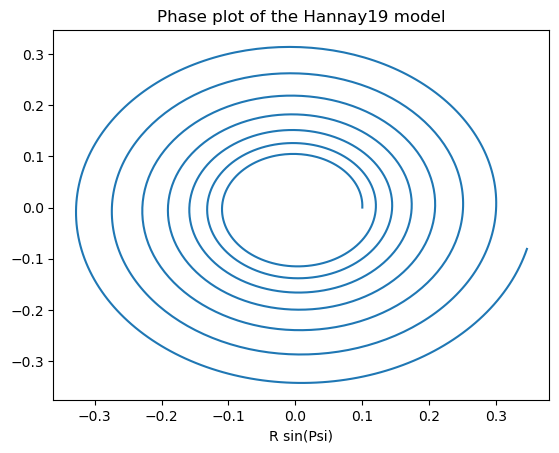

In [ ]:
spmodel = Hannay19()
ts = np.arange(0, 24*7, 0.10)
light_values = np.zeros(len(ts))
trajectory= spmodel(ts, light_values, np.array([0.10, 0.0,0.0]))

plt.plot(trajectory.states[0,:]*np.cos(trajectory.states[1,:]), trajectory.states[0,:]*np.sin(trajectory.states[1,:]))
plt.title("Phase plot of the Hannay19 model")
plt.xlabel("R cos(Psi)")
plt.xlabel("R sin(Psi)")

Because of the way the integration code is written it is simple to run a collection of initial conditions through the model by just adding an batch dimension (terminology taken from the machine learning literature). This shows an example of running the model through 

In [ ]:
from circadian.lights import LightSchedule

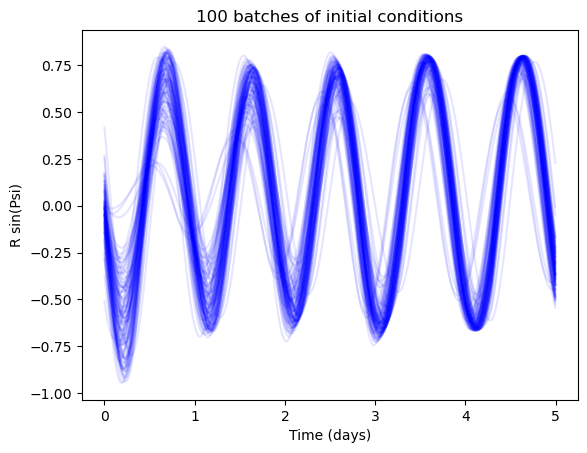

In [ ]:
spmodel = Hannay19()

ts = np.arange(0, 24*5, 0.10)
light_func = Light.ShiftWorkLight(dayson=3, daysoff=4)
light_values = light_func(ts)
num_batches = 100
initial_conditions_batch = np.array([0.70, np.pi,0.0]) + np.random.randn(num_batches,3)*0.20

trajectory = spmodel(ts, light_values, initial_conditions_batch)
for batch_idx in range(num_batches):
    plt.plot(trajectory.ts / 24.0, trajectory.states[batch_idx, 0,:]*np.sin(trajectory.states[batch_idx,1,:]), color='blue', alpha=0.10)
plt.title(f"{num_batches} batches of initial conditions")
plt.xlabel("Time (days)")
plt.ylabel("R sin(Psi)");

In [ ]:
#| hide  
dlmos_batch = []
for batch_idx in range(trajectory.batch_size):
    btrajectory = trajectory.get_batch(batch_idx)
    dlmos_batch.append(spmodel.dlmos(btrajectory))
    
dlmos_batch = np.array(dlmos_batch, dtype=object)

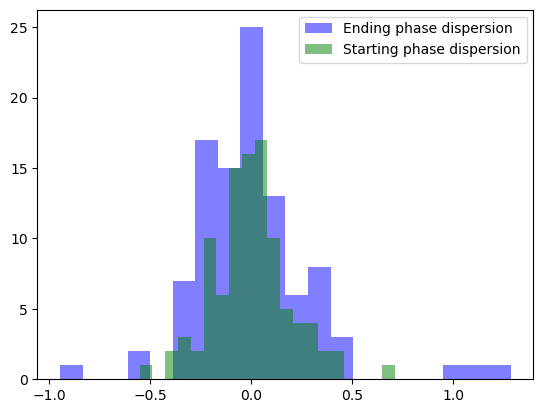

In [ ]:
plt.hist((trajectory.states[:,1,-1] - np.mean(trajectory.states[:,1,-1])) , bins=20, color='blue', alpha=0.5, label="Ending phase dispersion");
plt.hist((trajectory.states[:,1,0] - np.mean(trajectory.states[:,1,0])) , bins=20, color='green', alpha=0.5, label="Starting phase dispersion");
plt.legend();

We can also easily run the model over an batch of parameters just by passing in an array for the value of the parameters. The only gotcha is that you also need to pass in initial conditions which the same batch dimension to ensure the array arithmetic works out in the integrator.  

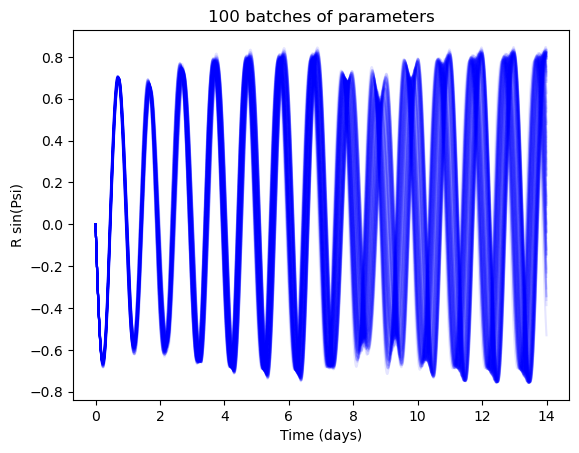

In [ ]:
num_batches = 100
spmodel = Hannay19({ 'tau' : np.linspace(23.5,24.5, num_batches), 'A1' : 0.32 + 0.05*np.random.randn(num_batches) })
initial_conditions_batch = np.array([0.70, np.pi,0.0]) + np.zeros((num_batches,3))
light_func = Light.ShiftWorkLight(dayson=2, daysoff=5)
ts = np.arange(0, 24*14, 0.10)
light_values = light_func(ts, repeat_period=24.0*7)
trajectory = spmodel.integrate_model(ts, light_est=light_values, state=initial_conditions_batch)
for batch_idx in range(num_batches):
    plt.plot(trajectory.ts / 24.0, trajectory.states[batch_idx, 0,:]*np.sin(trajectory.states[batch_idx,1,:]), color='blue', alpha=0.10)
plt.title(f"{num_batches} batches of parameters")
plt.xlabel("Time (days)")
plt.ylabel("R sin(Psi)");

## Models Coming Soon

## Non Photic Model ( Hilaire 2007) 

This implements the model from [@hilaire_addition_2007]. It describes the circadian state using the $(x, x_c, n)$ variables as seen in the other VDP based models. This model also uses sleep-wake information as a non-photic input. 



In [ ]:
#| export 

class Hilaire2007(CircadianModel):
    
    def __init__(self, params: dict = None):
        self._default_params() 
        if params is not None:
            self.set_parameters(params)
    
    def _default_params(self) -> dict:
        self.tx = 24.2;
        self.G = 37;
        self.k = .55;
        self.mu = .13;
        self.beta = 0.007;
        self.q = 1/3;
        self.rho = 0.032;
        
        # Light Parameters
        self.I0 = 9500;
        self.p = 0.5;
        self.a0 = 0.1;

        # Reference Parameters for phases
        self.phi_xcx = -2.98;
        self.phi_ref = 0.97;
        self.CBTmin = self.phi_xcx + self.phi_ref;
         
    def alphaNonPhotic(self, light_values: np.array) -> np.array:
        """
        The non-photic process L function
        """
        return self.a0*(np.power(light_values/self.I0,self.p))*(light_values/(light_values+100.0));
    
    def derv(self, 
             t, # time in hours
             y: np.array, # current state of the model (x, x_c, n)
             light: float, # light estimate in lux
             wake: float, # wake estimate (0.0 = asleep, 1.0 = awake)
             ) -> np.ndarray:
        """
        The derivative function for the Hilaire2007 NonPhotic Model
        """
        x = y[...,0]
        xc = y[...,1]
        n = y[..., 2]
        
        Bh = self.G * (1 - n) * self.alphaNonPhotic(light_values=light);
        B = Bh * (1 - .4 * x) * (1 - .4 * xc);

        #From St. Hilaire (2007): sigma equals either 1 (for sleep/rest) or 0 (for wake/activity),
        sigma = 1.0 if wake < 0.5 else 0.0
        Nsh = self.rho*(1/3 - sigma);
        
        # I'm confused about this part of the model
        C = t % 24;
        CBTminlocal = self.CBTmin*24.0/(2*np.pi);
        psi_cx = C - CBTminlocal
        psi_cx = psi_cx % 24;
        
        if (psi_cx > 16.5 and psi_cx < 21):
            Ns = self.rho*(1/3) 
        else:
            Ns = Nsh*(1 - np.tanh(10*x));
        
        dydt = np.zeros_like(y)
        dydt[...,0] = np.pi / 12.0 * (xc + self.mu*((1/3)*x + (4/3)*np.power(x,3.0) - 256/105*np.power(x,7.0)) + B + Ns);
        dydt[...,1] = np.pi / 12.0 * (self.q*B*xc - x*(np.power((24/(0.99729*self.tx)),2) + self.k*B));
        dydt[...,2] = 60.0 * (self.alphaNonPhotic(light) * (1.0 - n) - self.beta * n)
        
        return dydt
    
    def step_rk4(self,
                 t: float, #current time in hours
                 state: np.ndarray, #dy/dt = f(y, t)
                 light: float, #light value at time t in lux
                 wake: float, #wake estimate at time t (0.0 = asleep, 1.0 = awake)
                 dt=0.10 #step size in hours 
                 ):
        """
            Return the state of the model assuming a constant light value, wake estimate
            for one time step and using a fourth order Runga-Kutta integrator to perform the step
        """
        k1 = self.derv(t, state, light=light, wake=wake)
        k2 = self.derv(t, state + k1 * dt / 2.0, light=light, wake=wake)
        k3 = self.derv(t, state + k2 * dt / 2.0, light=light, wake=wake)
        k4 = self.derv(t, state + k3 * dt, light=light, wake=wake)
        state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        return state
    
    def integrate_model(self,
                        ts: np.ndarray,  # Array of time points, also determines step size of RK4 solver
                        light_est: np.ndarray,  # Array of light estimates, should be the same length as ts
                        wake_est: np.ndarray,  # Array of wake estimates, should be the same length as ts
                        state: np.ndarray,  # Initial state of the model
                        ) -> DynamicalTrajectory:
        n = len(ts)
        sol = np.zeros((*state.shape, n))
        sol[..., 0] = state
        for idx in range(1, n):
            state = self.step_rk4(ts[idx],
                state=state,
                light=light_est[idx],
                wake=wake_est[idx],
                dt=ts[idx]-ts[idx-1]
            )
            sol[..., idx] = state
        return DynamicalTrajectory(ts, sol)
    
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        cbt_mins = find_peaks(-1*trajectory.states[0,:])[0] # min of x is the CBTmin
        return trajectory.ts[cbt_mins] + self.phi_ref
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.cbt(trajectory) + self.dlmo_convert # dlmo is defines by a relationship to cbt for this model

    def amplitude(state) -> float:
        return np.sqrt(state[0]**2+state[1]**2)

    def phase(state) -> float:
        x= state[0] 
        y = state[1]*-1.0
        return np.angle(x + complex(0,1)*y)
        
    @property
    def default_initial_conditions(self) -> np.ndarray:
        return np.array([-0.3,-1.13,0.0])
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "St. Hilaire 2007 NonPhotic Model"

In [ ]:
hmodel = Hilaire2007() 

print(hmodel.derv(0, hmodel.default_initial_conditions, 1000, 1.0))
print(hmodel.step_rk4(0, hmodel.default_initial_conditions, 1000, 1.0))

[ 0.16975025 -0.02067777  1.76968823]
[-0.28695536 -1.13159738  0.15893028]


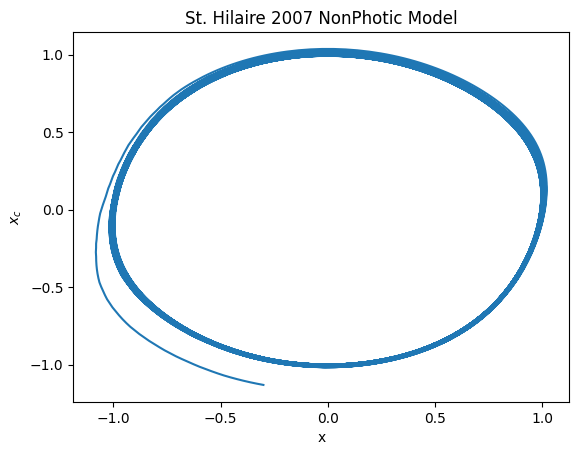

In [ ]:
sol = hmodel.integrate_model(np.arange(0, 24*100, 0.1),
                             np.random.rand(240*100), 
                             np.random.rand(240*100), 
                             hmodel.default_initial_conditions)

plt.plot(sol.states[0, :], sol.states[1,:]);
plt.title(hmodel.__str__());
plt.xlabel("x");
plt.ylabel("$x_c$");

## Kronauer-Jewett Model

From the revised limit cycle oscillator model paper.

In [ ]:
#| export 
class KronauerJewett(CircadianModel):
    """ 
        Higher order vdp model for the circadian clock 
    """
    
    def __init__(self, params: dict = None):
        self._default_params() 
        if params is not None:
            self.set_parameters(params)
        
    def _default_params(self) -> dict:
        self.taux = 24.2;
        self.G = 19.875;
        self.b = 0.013;
        self.k = .55;
        
        self.mu = .1300;
        self.q = 1.0/3;
        
        self.I0 = 9500;
        self.p = .6;
        self.a0 = 0.16;
        
        # Relational parameters to circadian markers
        self.phi_ref = 0.80; # relative to x min to get CBTmin, units of hours
        self.dlmo_convert = -7.0 #factor to convert from CBTmin to DLMO
        

    def alphaFunction(self, light_values: np.array) -> np.array:
        """
        Alpha process L function
        """
        return self.a0*(light_values/self.I0)**self.p;
    
    def derv(self, 
             y: np.array, #state vector (x, xc, n)
             light: float, #light value in lux
             ) -> np.array:
        
        x =y[..., 0]
        xc = y[..., 1]
        n = y[..., 2]
        
        alpha = self.alphaFunction(light);
        Bh = self.G*alpha*(1-n);
        B = Bh*(1-0.4*x)*(1-0.4*xc);
        
        dydt = np.zeros_like(y)
        dydt[...,0] = np.pi/12* (xc + self.mu*(1/3*x+4/3*x**3-256/105*x**7) + B);
        dydt[...,1] = np.pi/12* (self.q*B*xc - x*((24/(0.99729*self.taux))**2 + self.k*B));
        dydt[...,2] = 60*(alpha*(1-n) - self.b*n);
        
        return dydt
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        cbt_mins = find_peaks(-1*trajectory.states[0,:])[0] # min of x is the CBTmin
        return trajectory.ts[cbt_mins] + self.phi_ref
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.cbt(trajectory) + self.dlmo_convert # dlmo is defines by a relationship to cbt for this model

    def amplitude(state) -> float:
        return np.sqrt(state[0]**2+state[1]**2)

    def phase(state) -> float:
        x= state[0] 
        y = state[1]*-1.0
        return np.angle(x + complex(0,1)*y)
        
    @property
    def default_initial_conditions(self) -> np.ndarray:
        return np.array([-0.3,-1.13,0.0])
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "KronauerJewett"

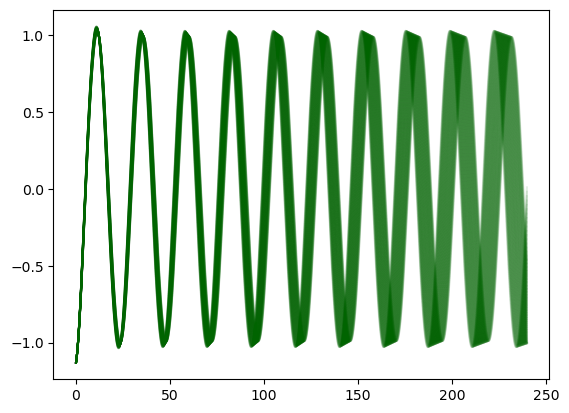

In [ ]:
kmodel = KronauerJewett({"taux": np.linspace(23.5,24.5, 100)})

ic = kmodel.default_initial_conditions + np.zeros((100, 3))
sim_days = 10
sol = kmodel(ts=np.arange(0, 24*sim_days, 0.1), light_est=np.zeros(240*sim_days), state=ic)

for batch_idx in range(sol.batch_size):
    plt.plot(sol.ts, sol.states[batch_idx, 1,:], color="darkgreen", alpha=0.1)

In [ ]:
np.diff(kmodel.cbt(sol.get_batch(0)))

array([24. , 23.5, 23.5, 23.5, 23.5, 23.5, 23.5, 23.5, 23.5, 23.5])

In [ ]:
np.diff(kmodel.dlmos(sol.get_batch(0)))

array([24. , 23.5, 23.5, 23.5, 23.5, 23.5, 23.5, 23.5, 23.5, 23.5])

## Phase Dynamics Model Nakao02 

[model](https://pubmed.ncbi.nlm.nih.gov/12375623/)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()